In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import yfinance as yf
import datetime

from valueinvesting import utils as utils

# 1. Load raw input
## Hardcoded block

In [2]:
evaluate_last_X_years = True
X=10
currency_pair = 'USD=X'
numbers_in_currency = 'USD'
share_name = 'SBSW'

# 1.1 Calculate Share numbers from total distributed dividend (CFS) and dividend amount

# 1.2. Raw input statement data

In [3]:
route = f"../data/input/{share_name}_data.csv"
data = pd.read_csv(route, sep=';', parse_dates=['date', 'real_date'])
# replace -, extend missing 0-s, fix datatype
data = utils.replace_format_input(data)

In [4]:
owned_shares = pd.read_csv('../data/extras/owned_stocks.csv', sep=';', parse_dates=['date'])
owned_shares = owned_shares.loc[(owned_shares['stock'] == share_name) & (owned_shares['active'] == 'yes')]

## (OPTIONAL) Time Filtering - Last 7 years daat

In [5]:
if evaluate_last_X_years:
    data = data[data['date'] > datetime.datetime.today() - datetime.timedelta(days=X*366+93)]
    data = data.reset_index(drop=True)

data.head()

,date,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,curr_assets,goodwill,...,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,shares,real_date
0,2014-12-31,1093,-729,364,89,49,86,28,168,64,...,235,48,0,309,226,1119,140,-174,915,2015-03-01
1,2015-06-30,861,-663,199,7,70,86,32,189,61,...,235,45,0,325,261,1111,116,-131,914,2015-08-29
2,2015-12-31,920,-622,298,35,46,105,26,177,47,...,178,128,0,344,116,854,157,-131,920,2016-02-29
3,2016-06-30,956,-605,359,6,59,145,38,242,66,...,264,257,0,556,221,1257,161,-115,925,2016-08-29
4,2016-12-31,1172,-805,367,217,71,420,49,563,68,...,379,55,0,456,601,1828,139,-168,1420,2017-03-01


## Calculate date when quaterly reports could be available

In [6]:
data = utils.calculate_real_date(data)

# 2. Filter out unnecesary columns

In [7]:
data = utils.filter_raw_data(data)
data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,intangible_assets,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex
15,2022-06-30,2022-08-29,2831,4570,-3263,1307,803,1673,437,1658,...,0,9736,883,7,0,1152,1275,4249,285,-399
16,2022-12-31,2023-03-01,2831,3878,-2945,933,359,1531,440,1549,...,0,9783,919,7,0,1187,1327,4441,664,-572
17,2023-06-30,2023-08-29,2831,3326,-2728,598,427,1176,425,1364,...,0,9569,816,7,0,957,1336,4260,272,-596
18,2023-12-31,2024-02-29,2831,2846,-2689,157,-2459,1376,479,1420,...,0,7696,887,834,0,1962,1343,4919,113,-621
19,2024-06-30,2024-09-16,2831,2949,-2788,161,-379,844,485,1403,...,0,7320,836,256,0,1340,1769,5225,207,-595


## Pull historical average USD national currency rates and add to the dataframe

In [8]:
if currency_pair != 'USD=X':
    data['usd_nat_currency'] = utils.daily_price(
        ticker=currency_pair,
        end=data['date'],
        days_earlier=90
        )
else:
    data['usd_nat_currency'] = [1 for x in range(len(data))]

# drop rows, when USD rates wasn't available
data = data[data['usd_nat_currency'].notna()]

data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
15,2022-06-30,2022-08-29,2831,4570,-3263,1307,803,1673,437,1658,...,9736,883,7,0,1152,1275,4249,285,-399,1
16,2022-12-31,2023-03-01,2831,3878,-2945,933,359,1531,440,1549,...,9783,919,7,0,1187,1327,4441,664,-572,1
17,2023-06-30,2023-08-29,2831,3326,-2728,598,427,1176,425,1364,...,9569,816,7,0,957,1336,4260,272,-596,1
18,2023-12-31,2024-02-29,2831,2846,-2689,157,-2459,1376,479,1420,...,7696,887,834,0,1962,1343,4919,113,-621,1
19,2024-06-30,2024-09-16,2831,2949,-2788,161,-379,844,485,1403,...,7320,836,256,0,1340,1769,5225,207,-595,1


## Convert USD values related to IS, BS, CFS to national currency

In [9]:
# convert columns into national currency if necessary
if numbers_in_currency == 'USD':
    data_nat_curr = utils.convert_national_currency(input_data=data, currency=data)
else:
    data_nat_curr = data.copy()
data_nat_curr.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
15,2022-06-30,2022-08-29,2831,4570.0,-3263.0,1307.0,803.0,1673.0,437.0,1658.0,...,9736.0,883.0,7.0,0.0,1152.0,1275.0,4249.0,285.0,-399.0,1
16,2022-12-31,2023-03-01,2831,3878.0,-2945.0,933.0,359.0,1531.0,440.0,1549.0,...,9783.0,919.0,7.0,0.0,1187.0,1327.0,4441.0,664.0,-572.0,1
17,2023-06-30,2023-08-29,2831,3326.0,-2728.0,598.0,427.0,1176.0,425.0,1364.0,...,9569.0,816.0,7.0,0.0,957.0,1336.0,4260.0,272.0,-596.0,1
18,2023-12-31,2024-02-29,2831,2846.0,-2689.0,157.0,-2459.0,1376.0,479.0,1420.0,...,7696.0,887.0,834.0,0.0,1962.0,1343.0,4919.0,113.0,-621.0,1
19,2024-06-30,2024-09-16,2831,2949.0,-2788.0,161.0,-379.0,844.0,485.0,1403.0,...,7320.0,836.0,256.0,0.0,1340.0,1769.0,5225.0,207.0,-595.0,1


# 3. Calculate input to Value Raios (eps, bv per share, fcf)
## filter out unwanted columns

In [10]:
filtered_nat_curr = utils.calculate_input_value_ratios(data_nat_curr, report='half-year')

## Calculate input values to value ratios

In [11]:
ratios_nat_curr = utils.ratios_input_filter(filtered_nat_curr)

## Calculate performance parameters (current ratio, ROA, ROE, margins, D/E)

In [12]:
ratios_nat_curr = utils.evaluate_performance(input=filtered_nat_curr, output=ratios_nat_curr, report='half-year')

# 4. Pull historical share prices and merge with sattement data

In [13]:
# pull weekly share prices and merge with the value ratios
merged_nat_curr = utils.add_share_prices_to_value_ratios(share_name, data, ratios_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,equity_ratio,debt_ratio,acc_rec_ratio,acc_pay_ratio,cash_turnover,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe
0,2015-03-02,6.154659,2014-12-31,1093.0,0.0,1.416393,915.0,0.0,0.0,49.0,...,0.536646,0.463354,0.0,0.0,0.0,0.0,0.333028,0.081427,0.0,0.0
1,2015-03-09,6.010691,2014-12-31,1093.0,0.0,1.416393,915.0,0.0,0.0,49.0,...,0.536646,0.463354,0.0,0.0,0.0,0.0,0.333028,0.081427,0.0,0.0
2,2015-03-16,6.514580,2014-12-31,1093.0,0.0,1.416393,915.0,0.0,0.0,49.0,...,0.536646,0.463354,0.0,0.0,0.0,0.0,0.333028,0.081427,0.0,0.0
3,2015-03-23,6.717724,2014-12-31,1093.0,0.0,1.416393,915.0,0.0,0.0,49.0,...,0.536646,0.463354,0.0,0.0,0.0,0.0,0.333028,0.081427,0.0,0.0
4,2015-03-30,6.466731,2014-12-31,1093.0,0.0,1.416393,915.0,0.0,0.0,49.0,...,0.536646,0.463354,0.0,0.0,0.0,0.0,0.333028,0.081427,0.0,0.0


# Calculate price ratios (P/E, P/B, P/S, P/FCF)

In [14]:
merged_nat_curr = utils.price_ratios(merged_nat_curr, report='half-year')
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,pfcf_ratio
0,2015-03-02,6.154659,2014-12-31,1093.0,0.0,1.416393,915.0,0.0,0.0,49.0,...,0.0,0.333028,0.081427,0.0,0.0,inf,4.345303,inf,inf,inf
1,2015-03-09,6.010691,2014-12-31,1093.0,0.0,1.416393,915.0,0.0,0.0,49.0,...,0.0,0.333028,0.081427,0.0,0.0,inf,4.243659,inf,inf,inf
2,2015-03-16,6.514580,2014-12-31,1093.0,0.0,1.416393,915.0,0.0,0.0,49.0,...,0.0,0.333028,0.081427,0.0,0.0,inf,4.599414,inf,inf,inf
3,2015-03-23,6.717724,2014-12-31,1093.0,0.0,1.416393,915.0,0.0,0.0,49.0,...,0.0,0.333028,0.081427,0.0,0.0,inf,4.742837,inf,inf,inf
4,2015-03-30,6.466731,2014-12-31,1093.0,0.0,1.416393,915.0,0.0,0.0,49.0,...,0.0,0.333028,0.081427,0.0,0.0,inf,4.565632,inf,inf,inf


# Calculate Dividend yield and currency-share price correlation

In [15]:
# get daily historical USD-national currency rates
usd_nat_curr = utils.get_historical_currency_rate(currency_pair, merged_nat_curr)

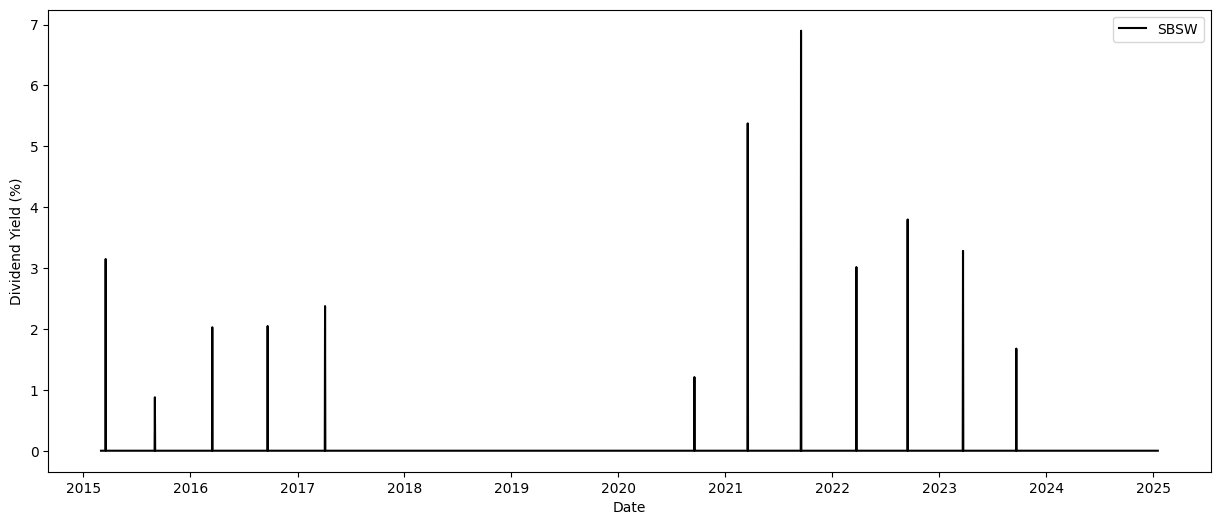

In [16]:
# get share prices and dividend yield data
ticker_all_price = utils.get_historical_share_dividend(share_name, merged_nat_curr)

currency_rate   NaN
share_price     NaN
Name: share_price, dtype: float64


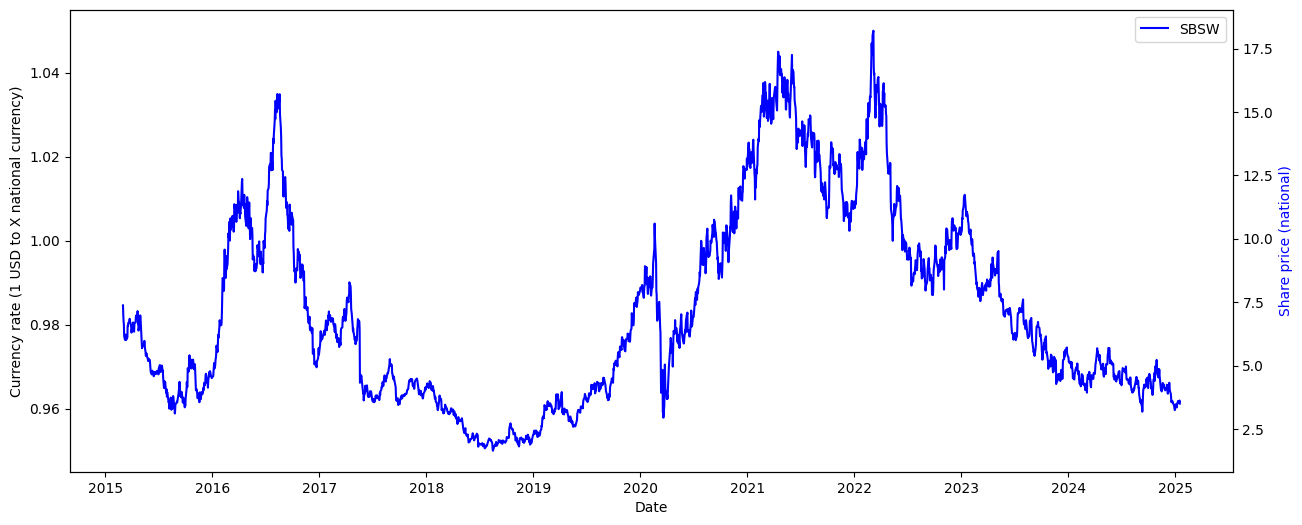

In [17]:
# Pearson's correlation coefficient between share price and USD - national currency rate
utils.get_currency_share_price_correlation(share_name, usd_nat_curr, ticker_all_price)

# Share price and value ratios

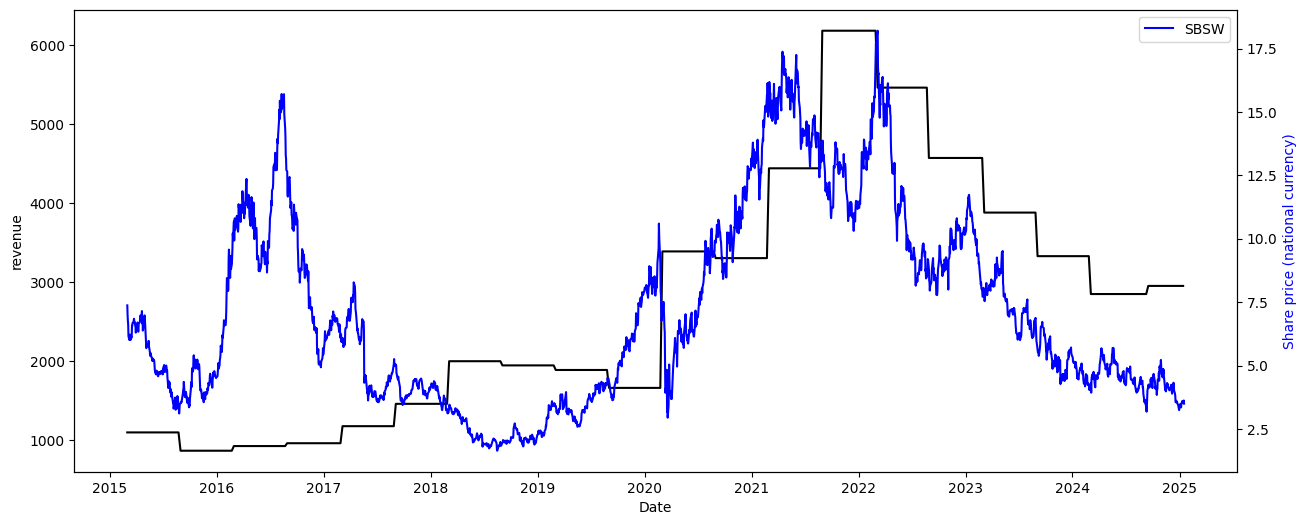

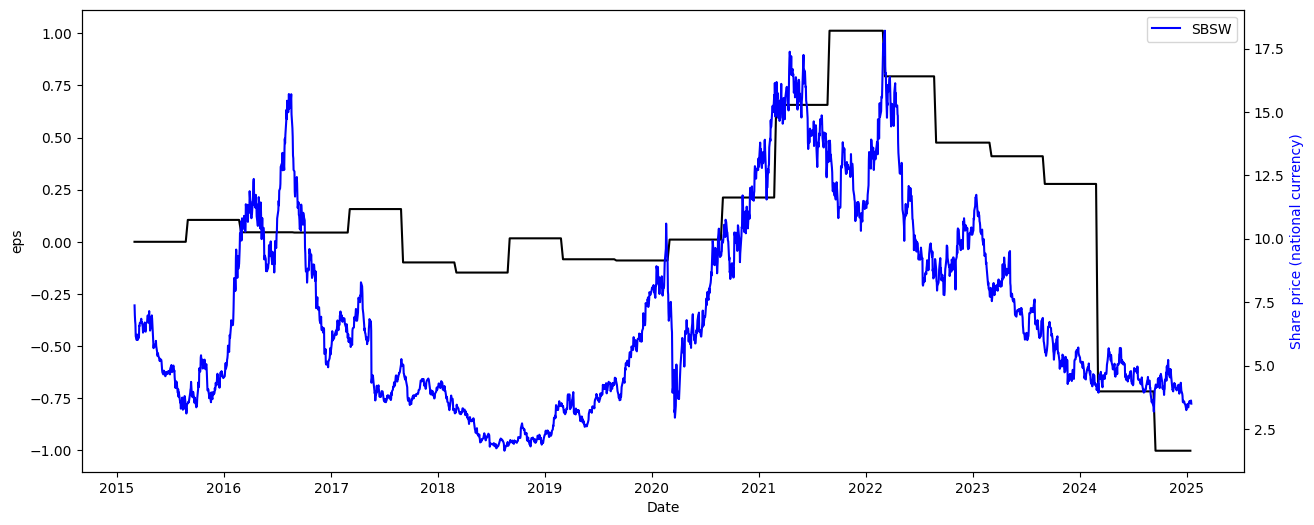

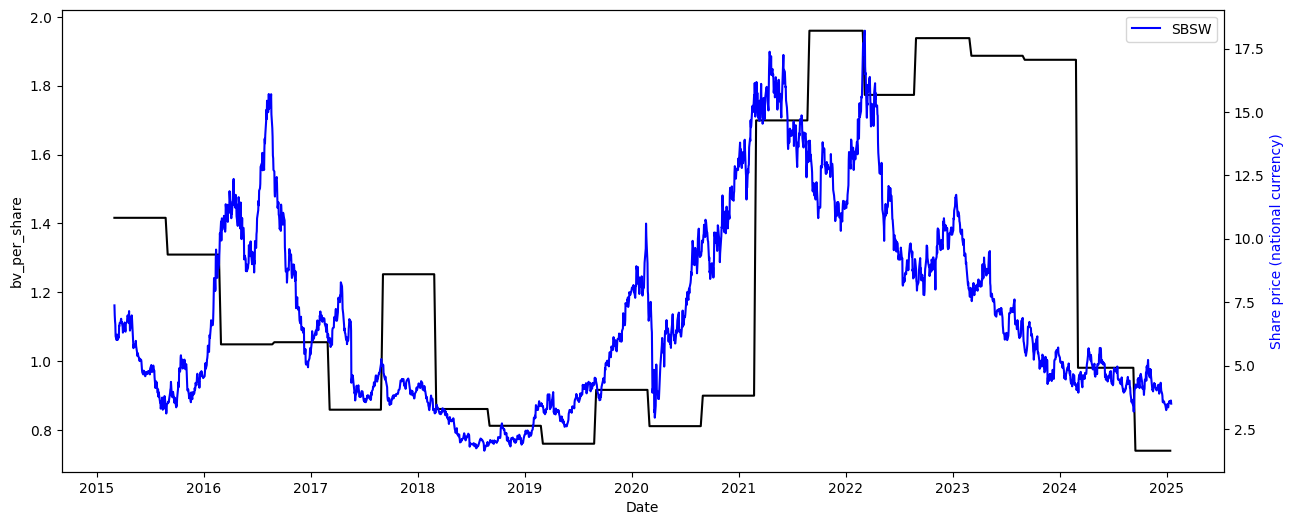

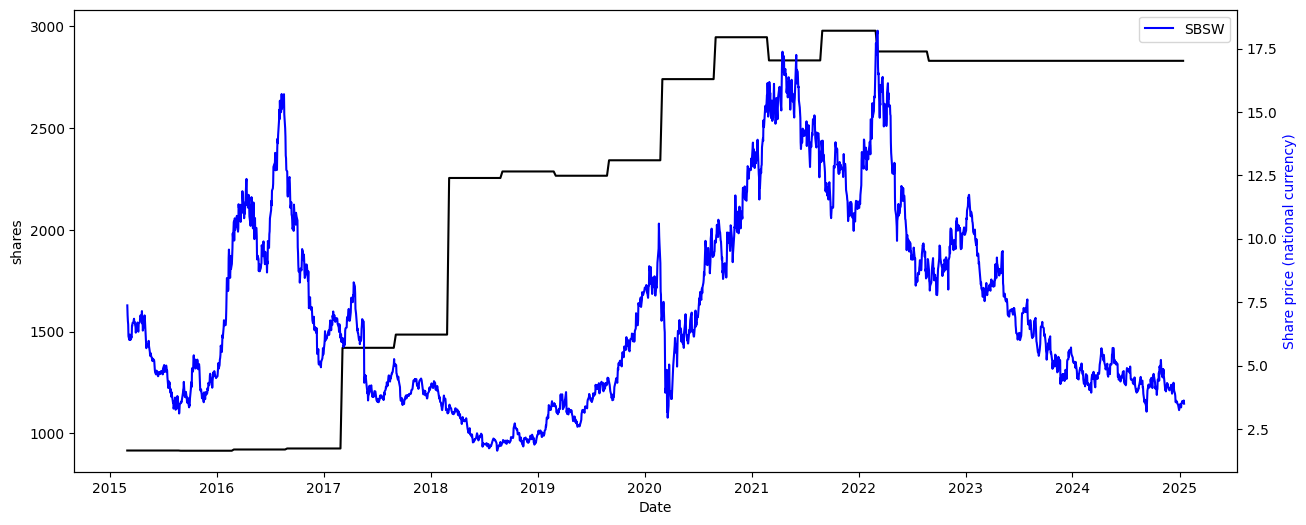

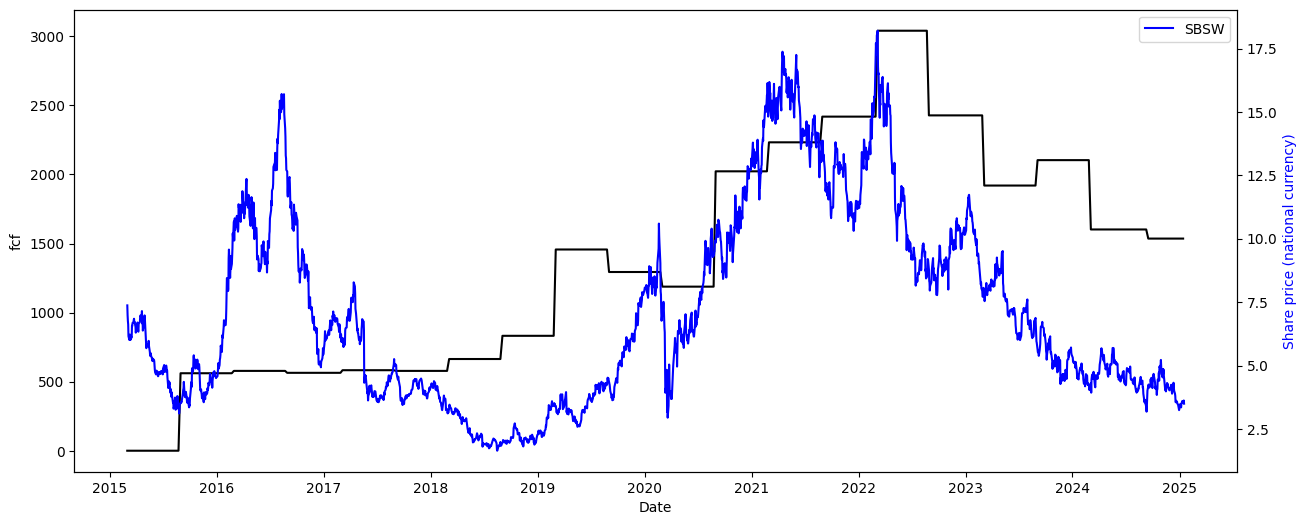

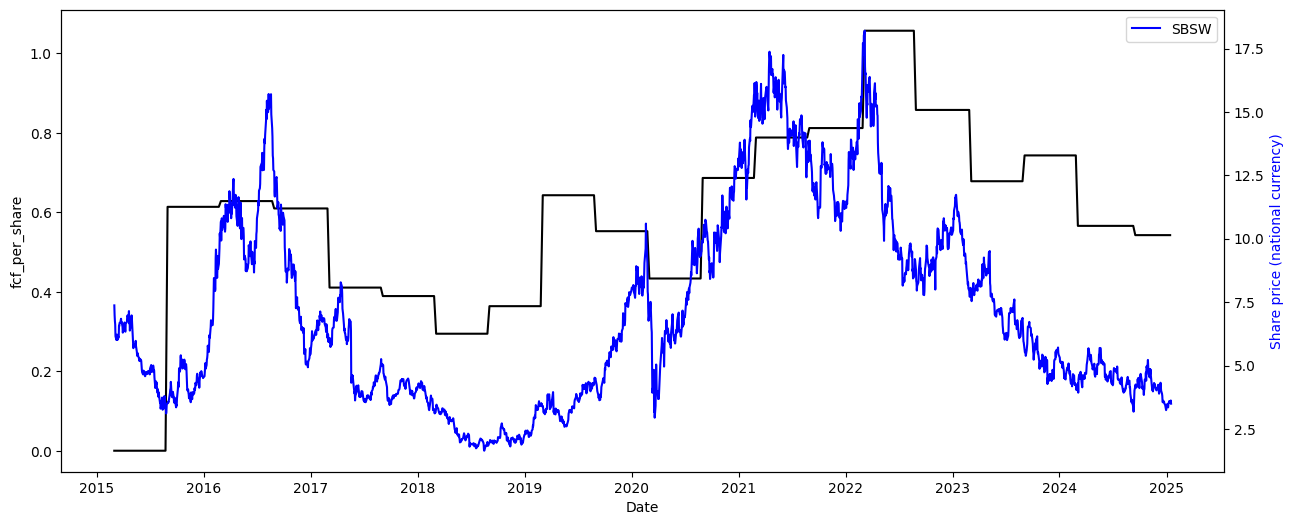

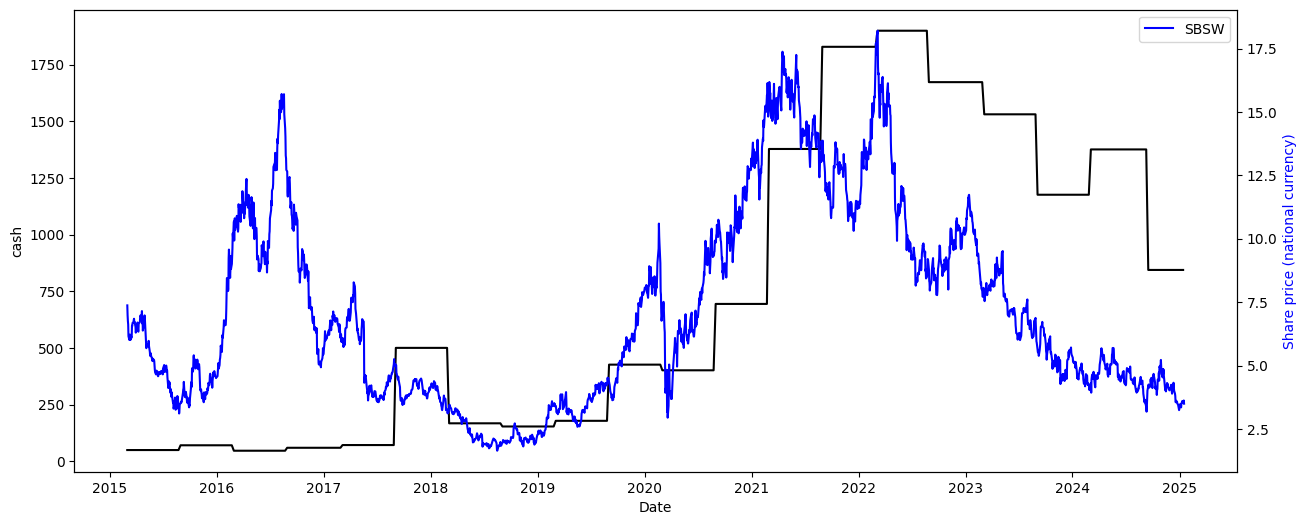

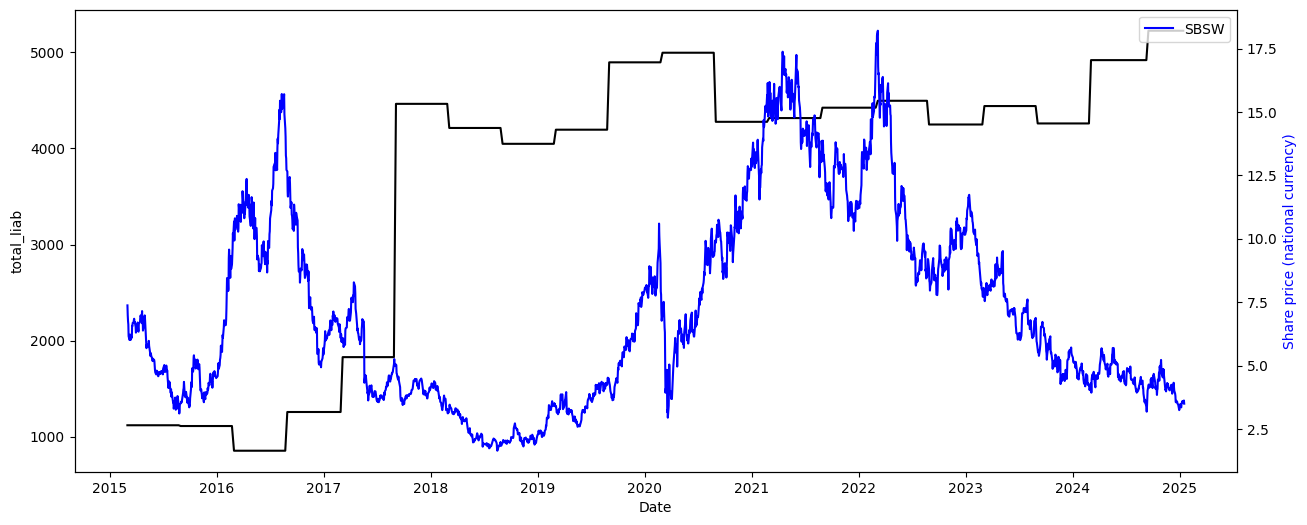

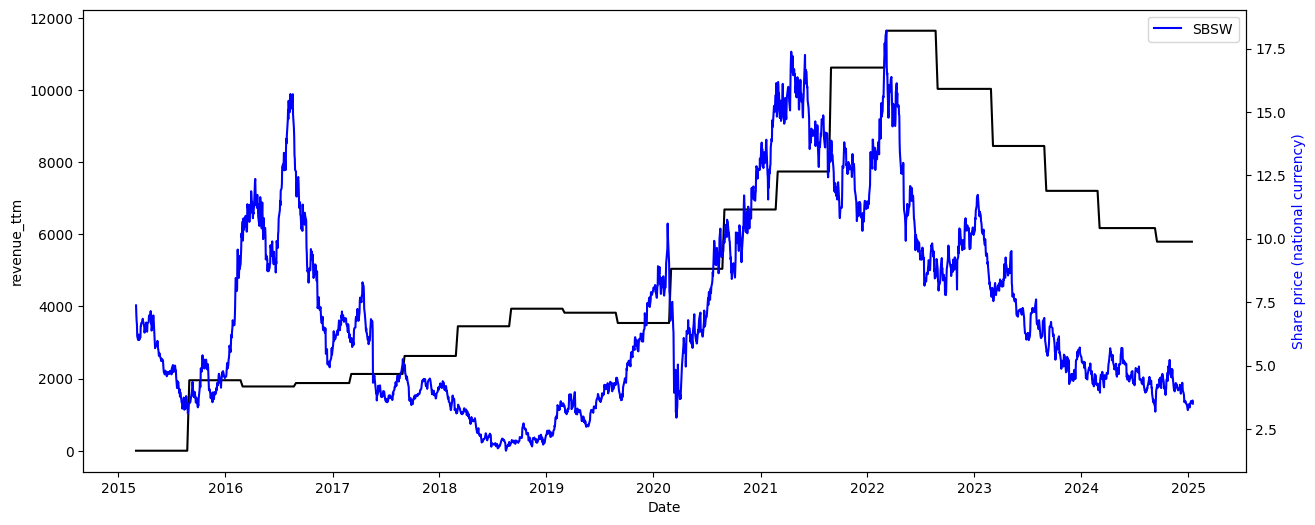

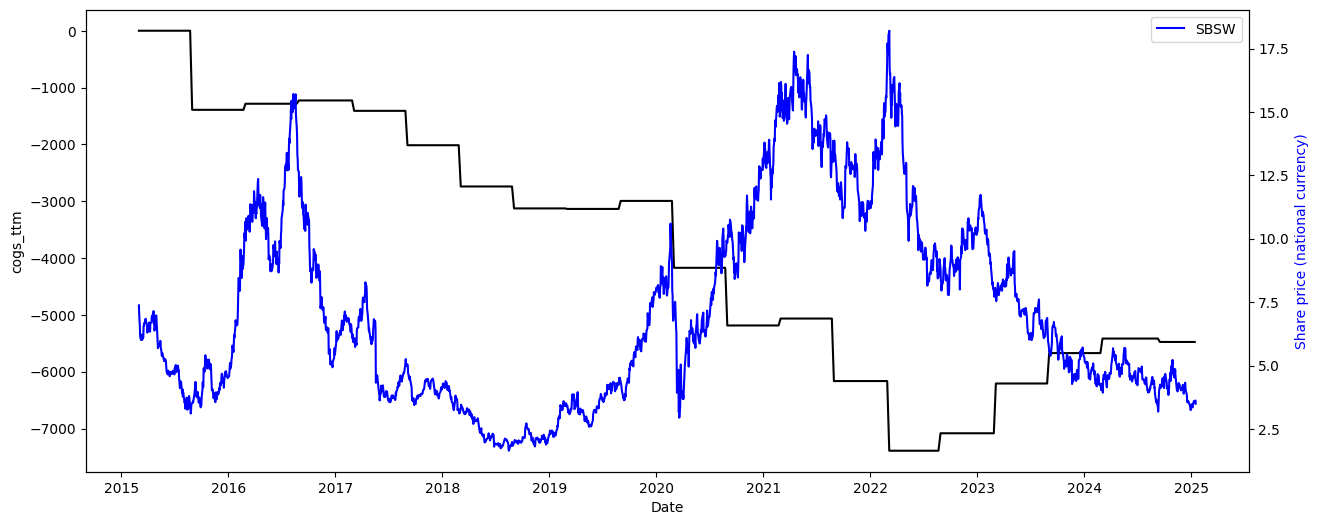

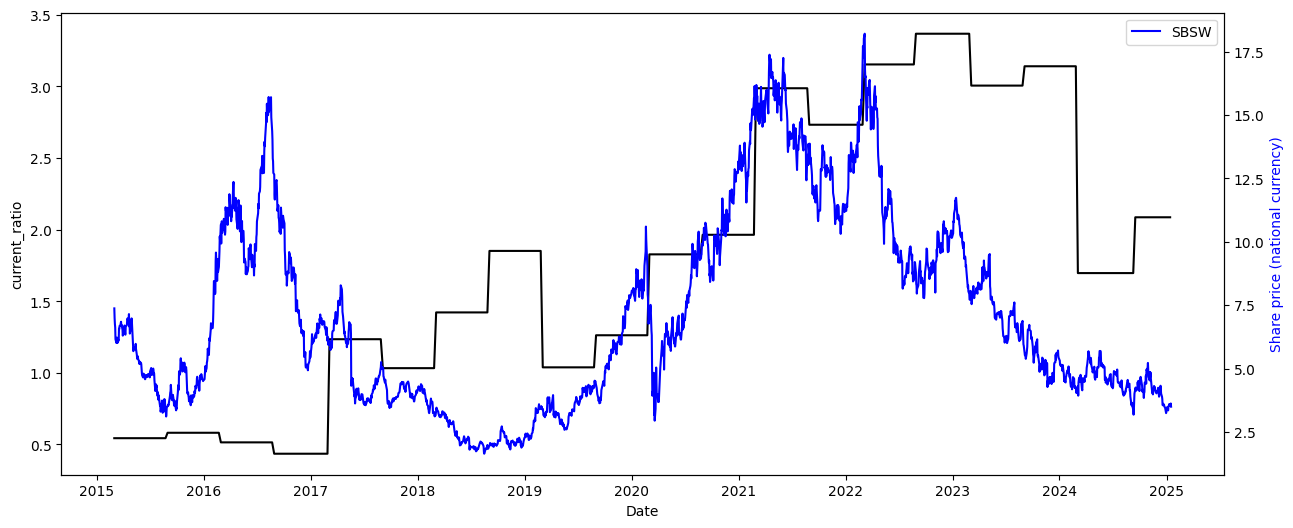

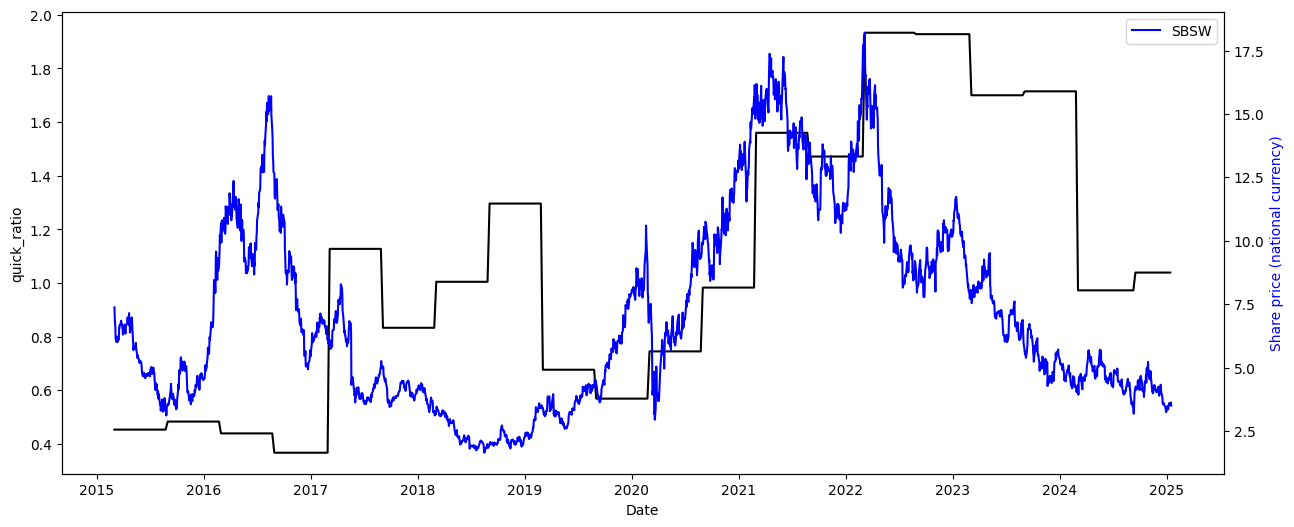

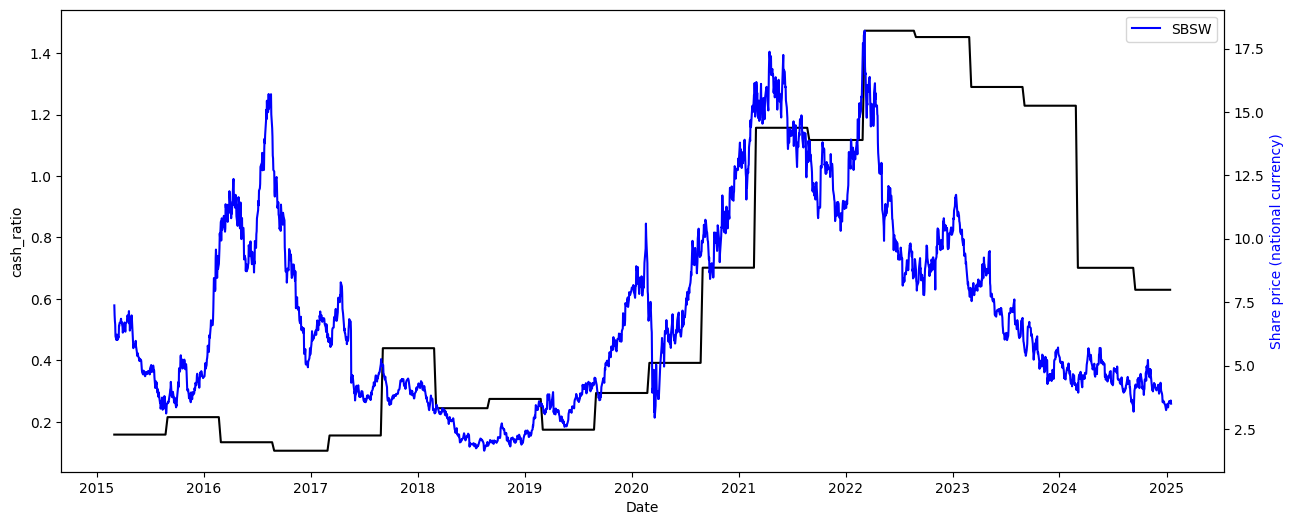

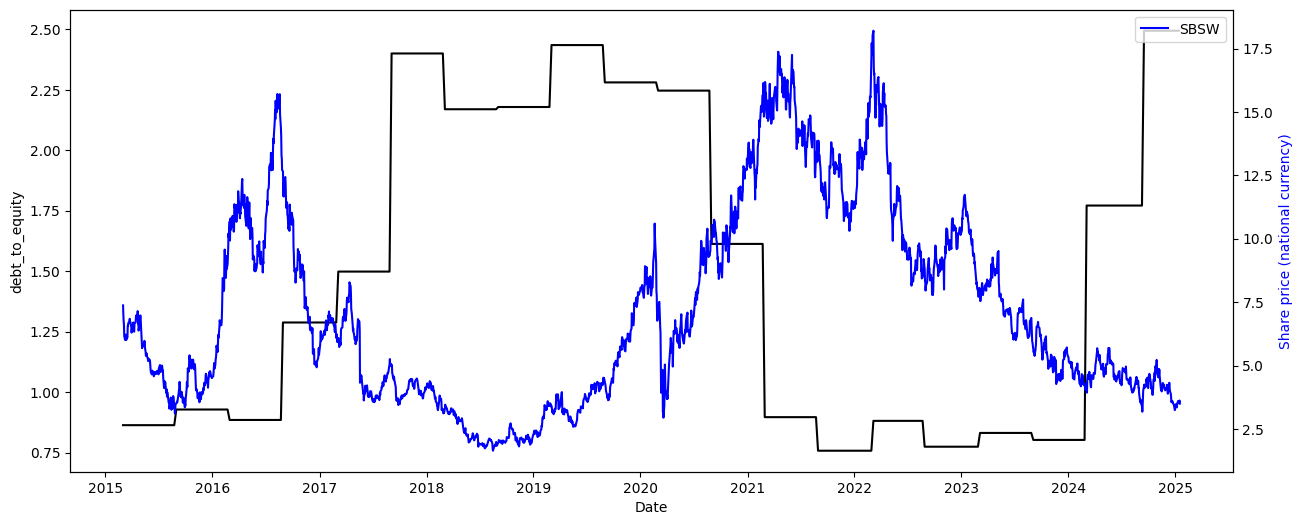

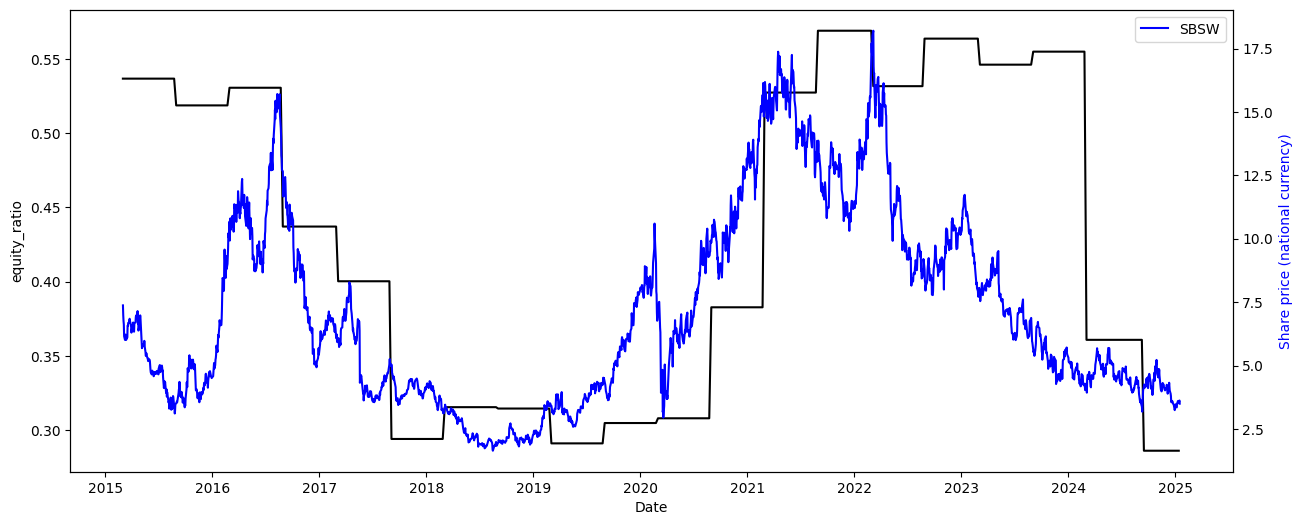

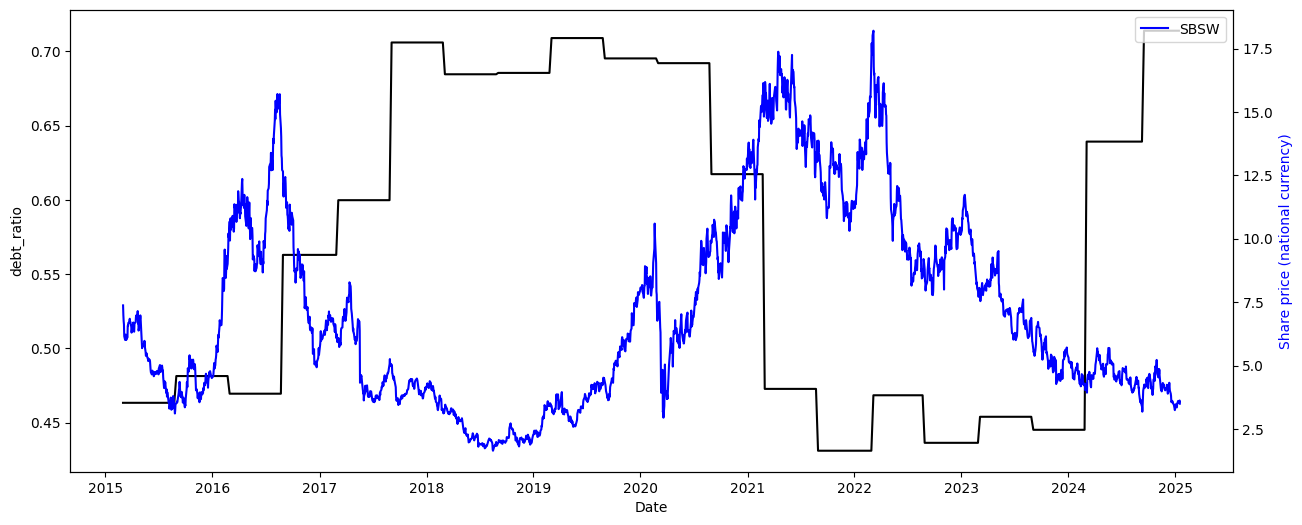

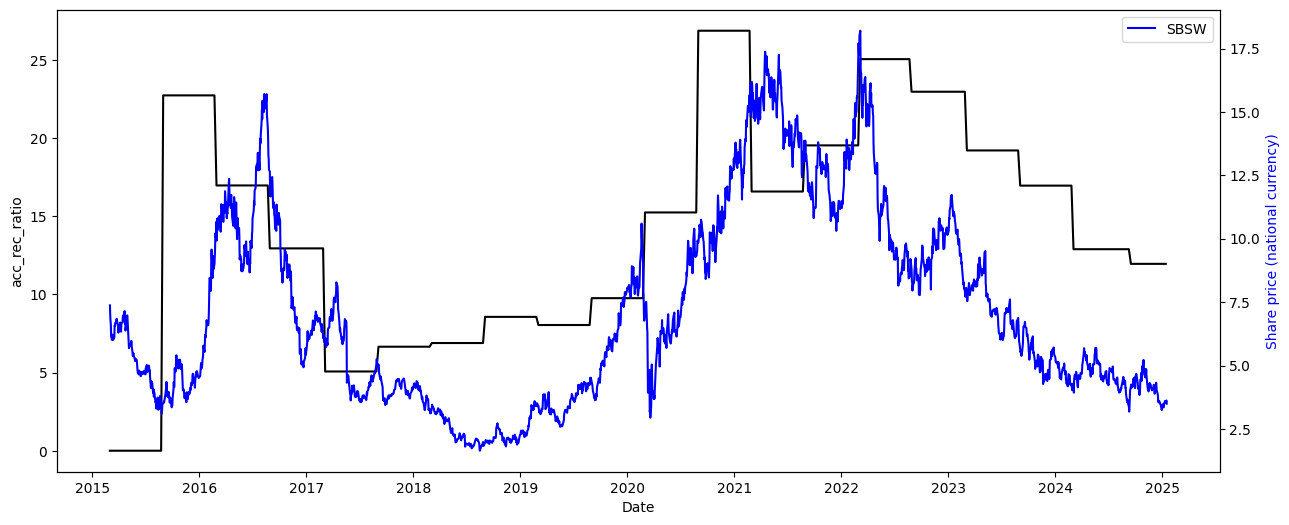

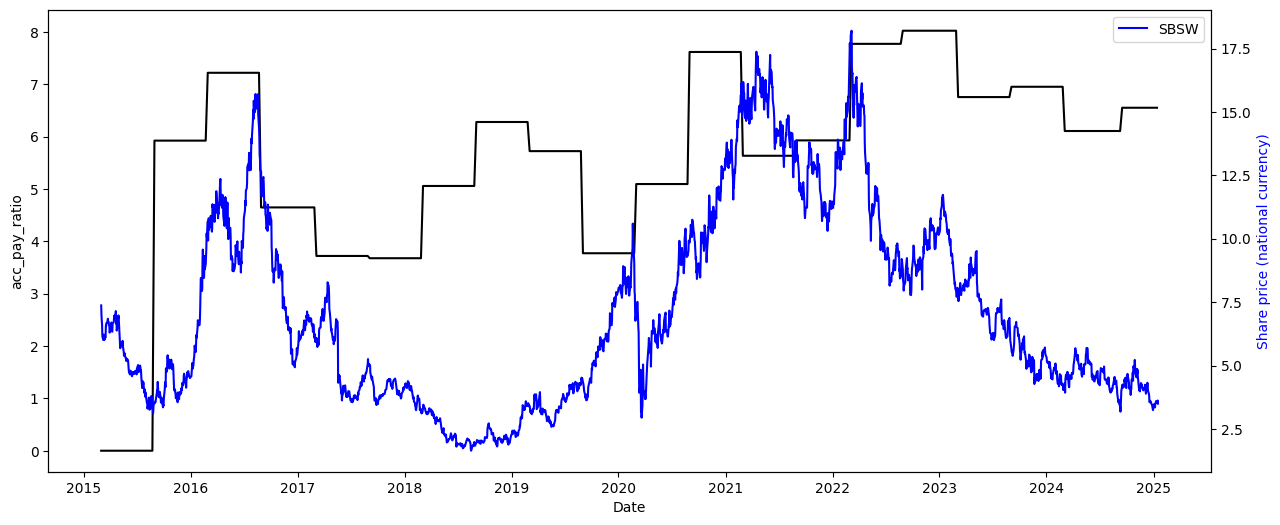

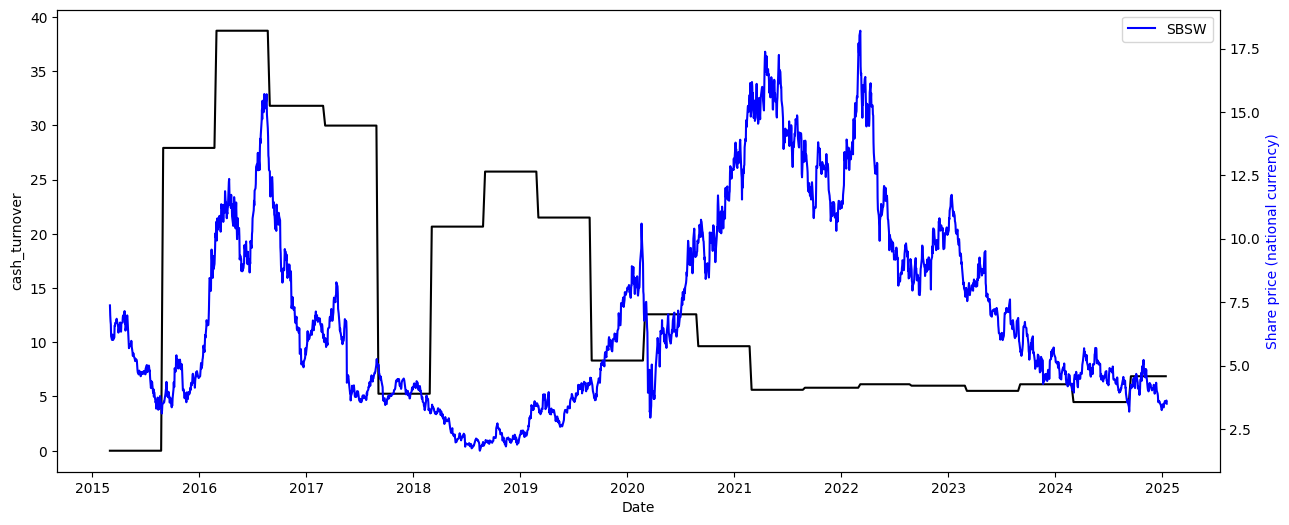

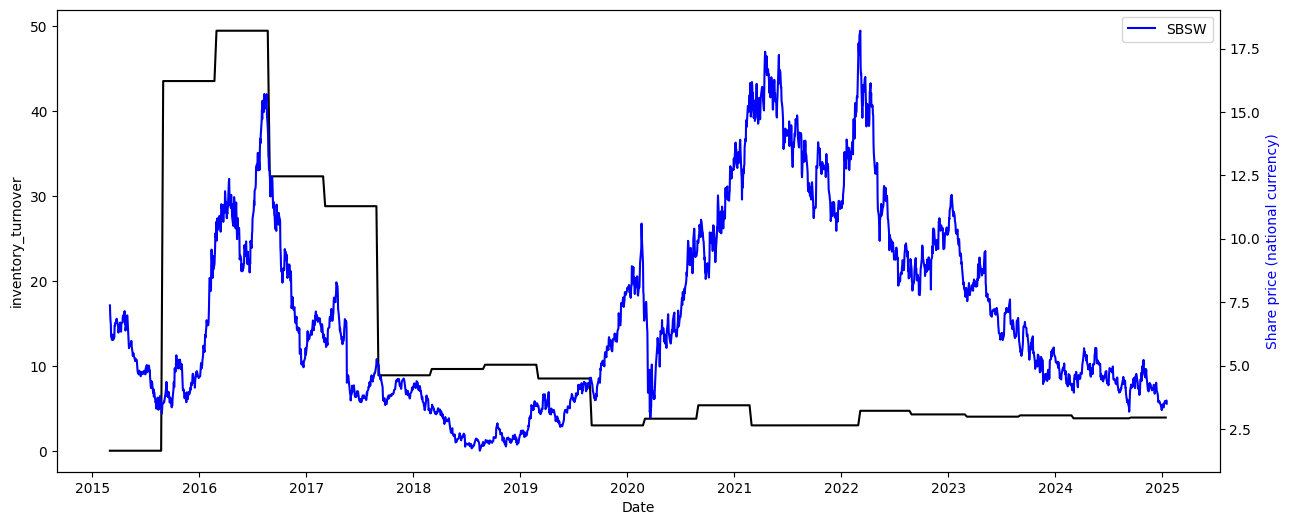

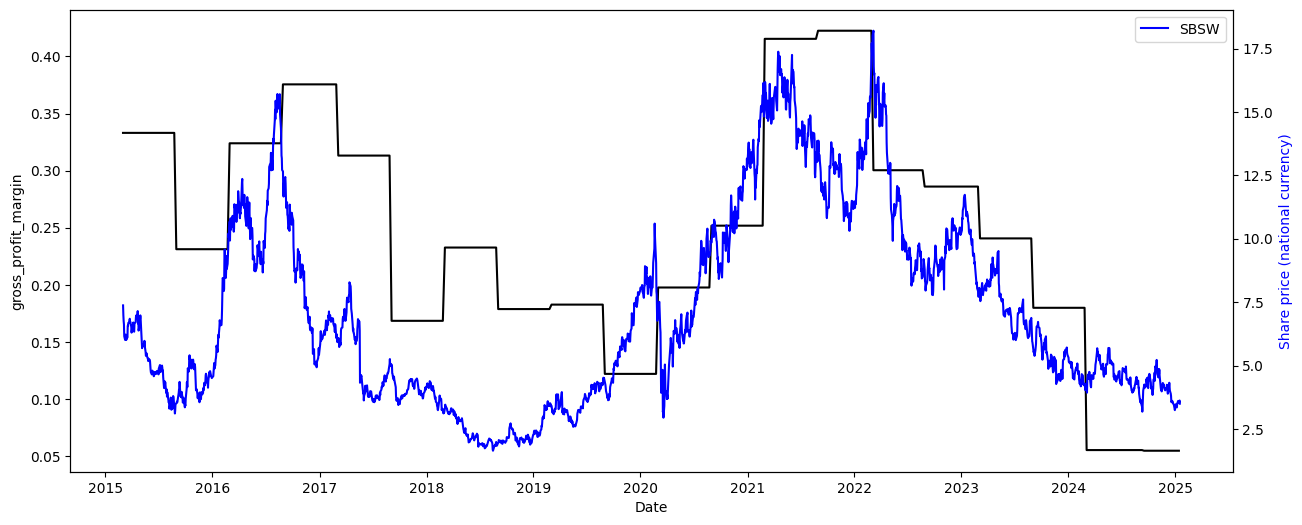

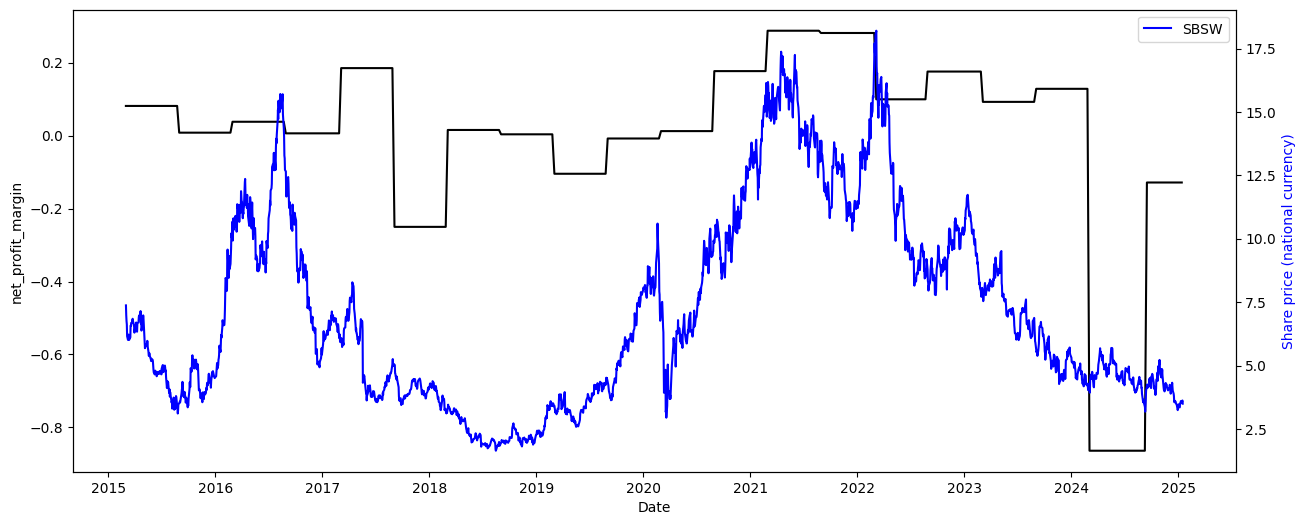

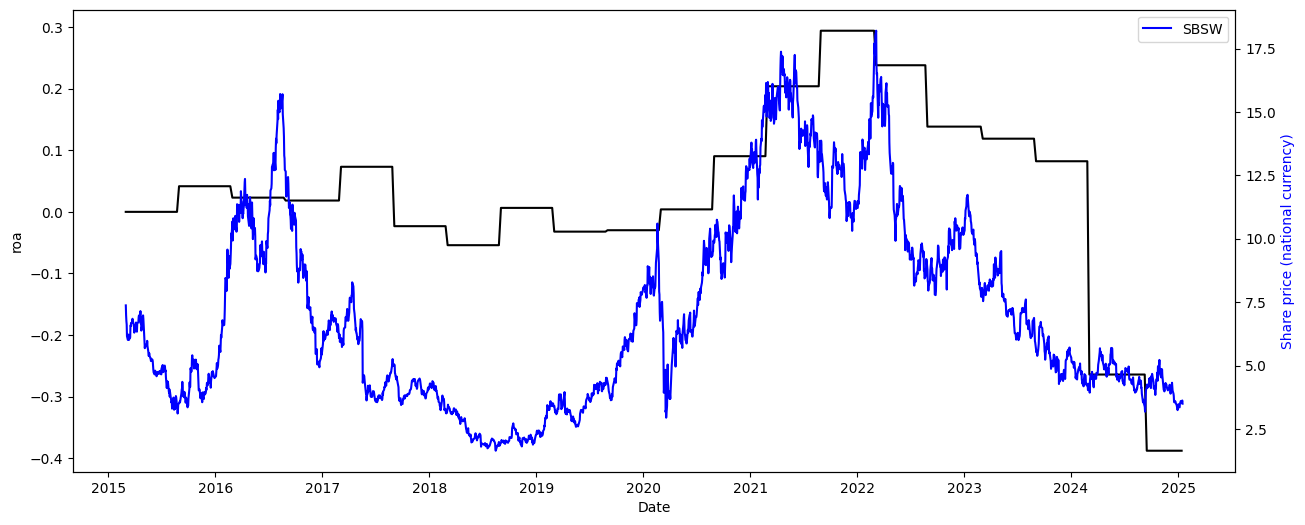

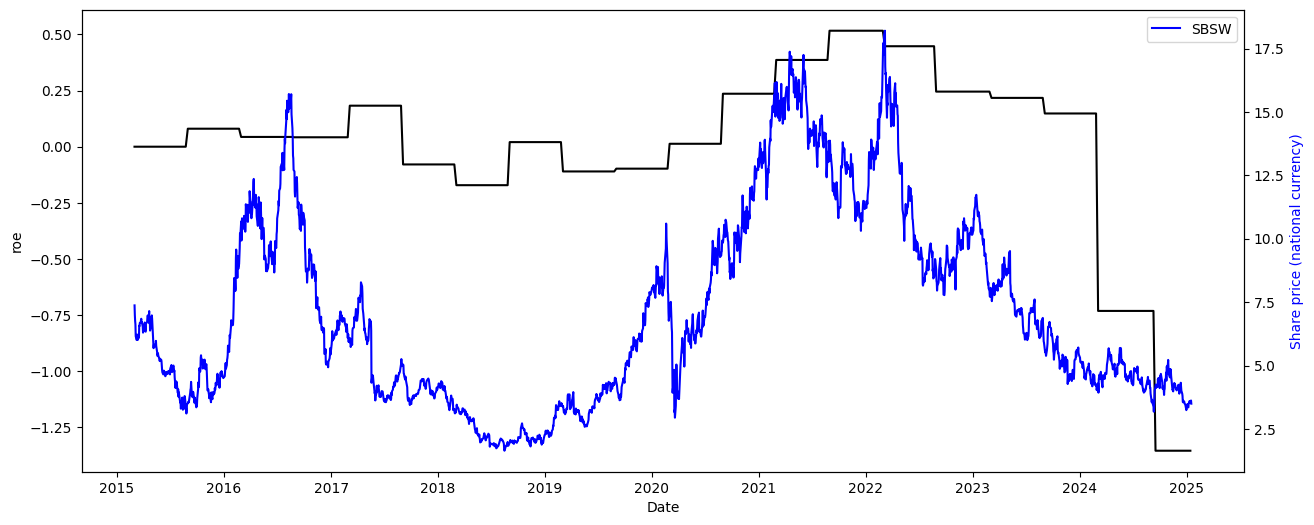

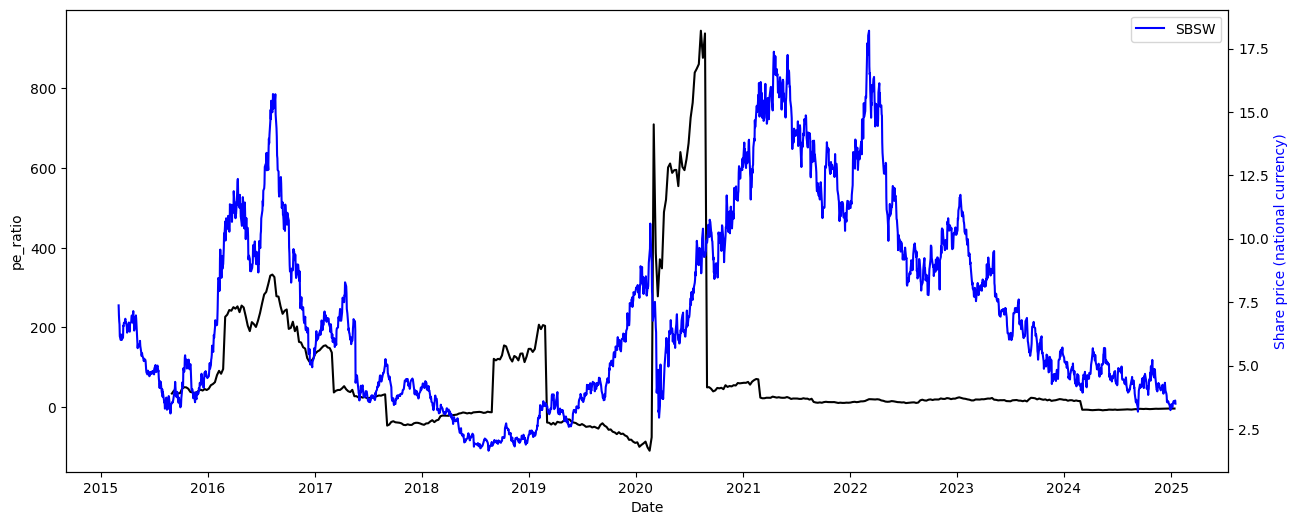

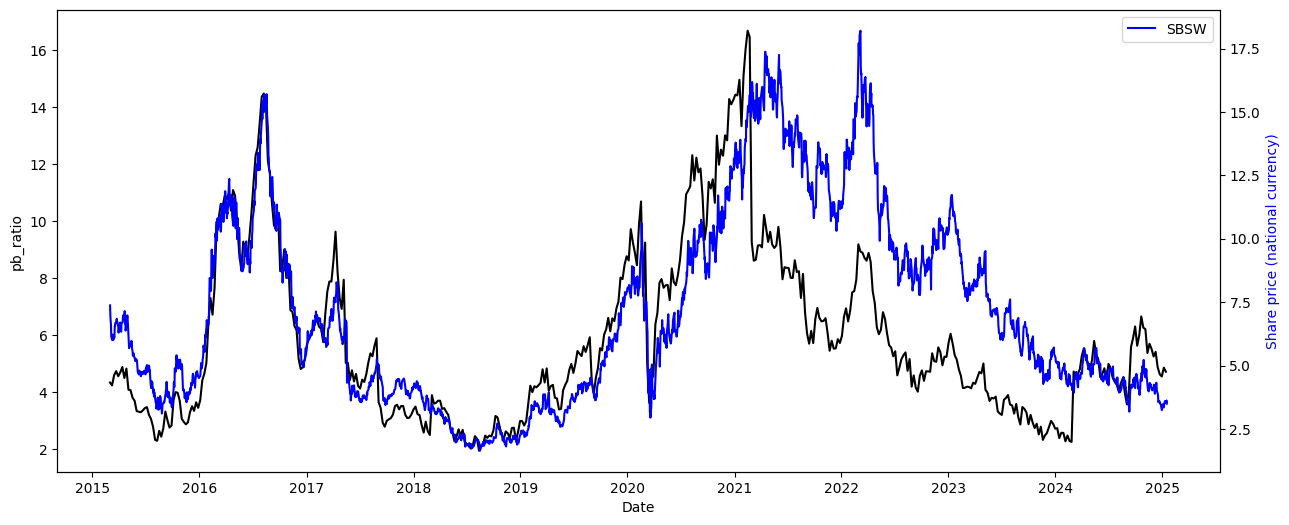

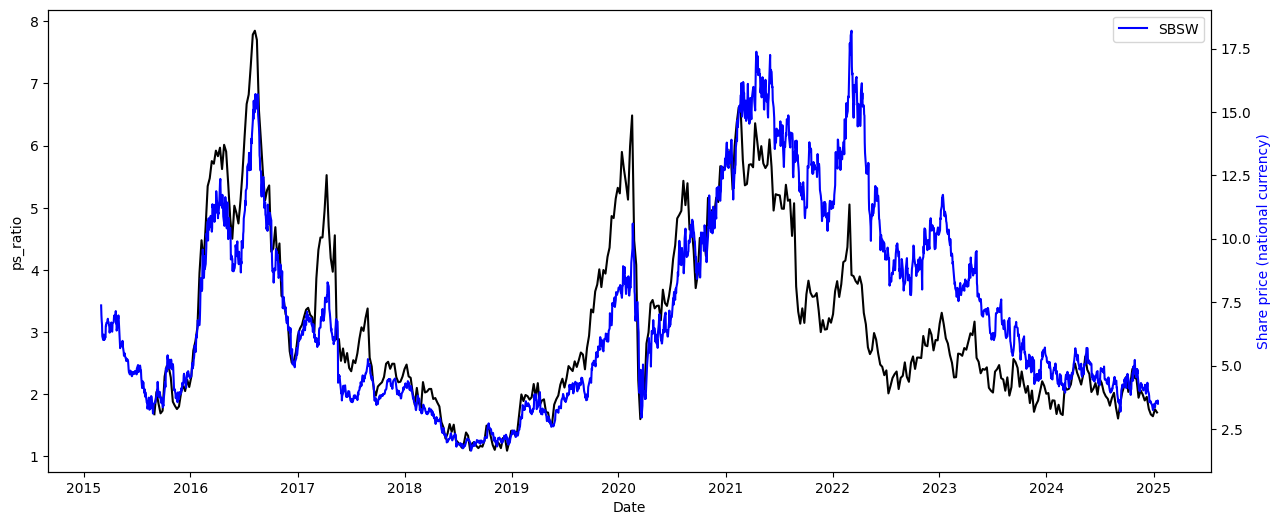

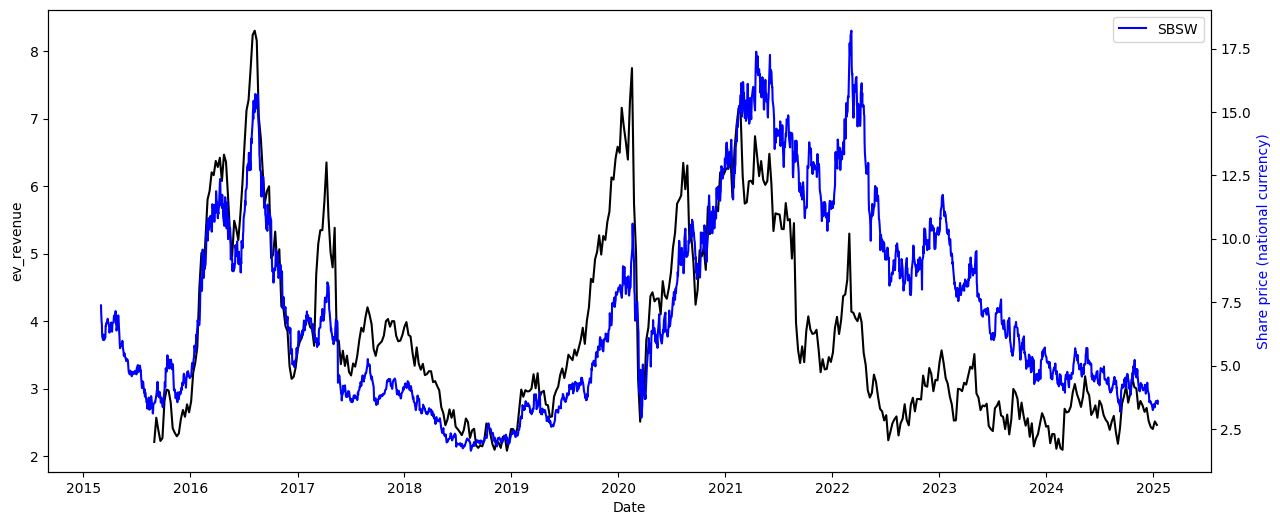

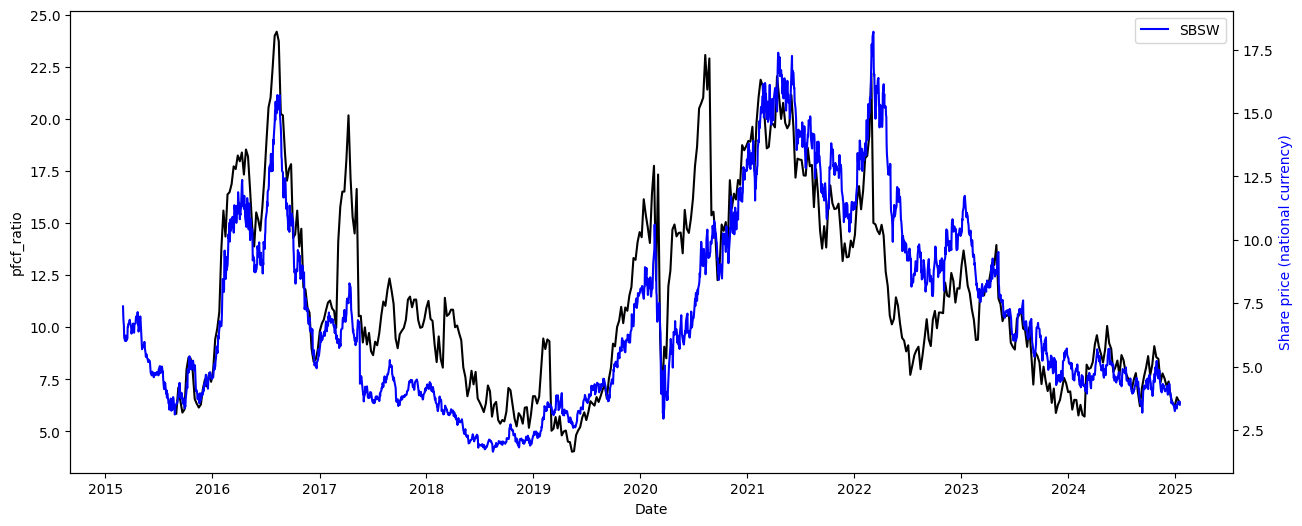

In [18]:
for column in merged_nat_curr.columns[3:]:
    fig, ax1 = plt.subplots(figsize=(15, 6))

    ax2 = ax1.twinx()
    ax1.plot(merged_nat_curr['real_date'], merged_nat_curr[column], color='k', label=merged_nat_curr)
    ax2.plot(ticker_all_price.index, ticker_all_price['Close'], color='b', label=share_name)

    ax1.set_xlabel('Date')
    ax1.set_ylabel(column, color='k')
    ax2.set_ylabel('Share price (national currency)', color='b')

    plt.legend()
    plt.show()

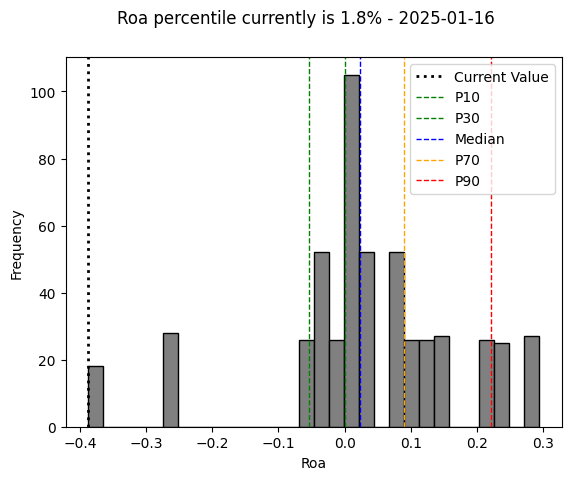

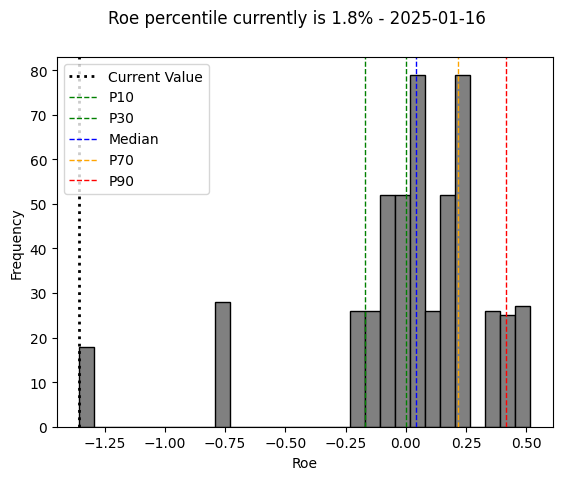

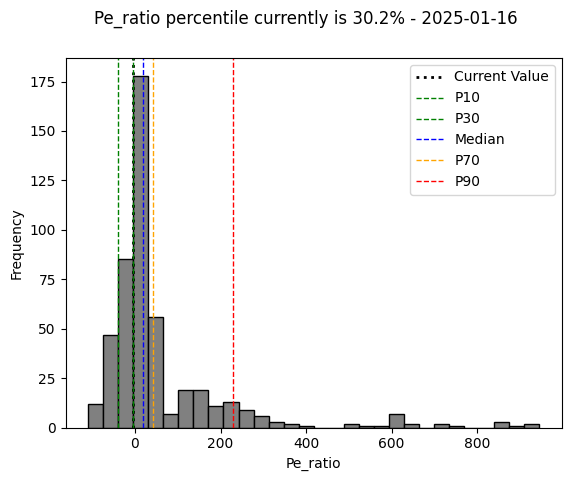

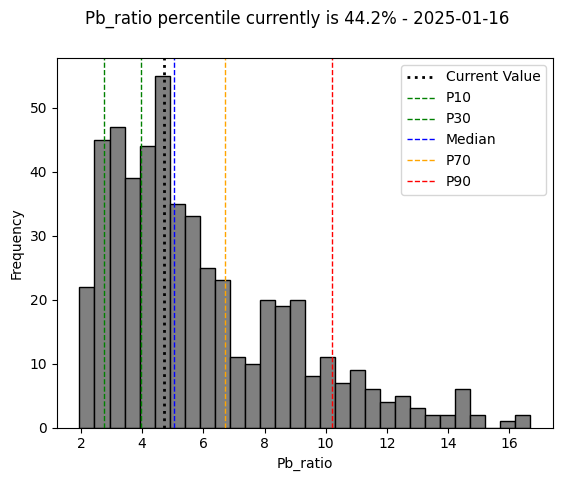

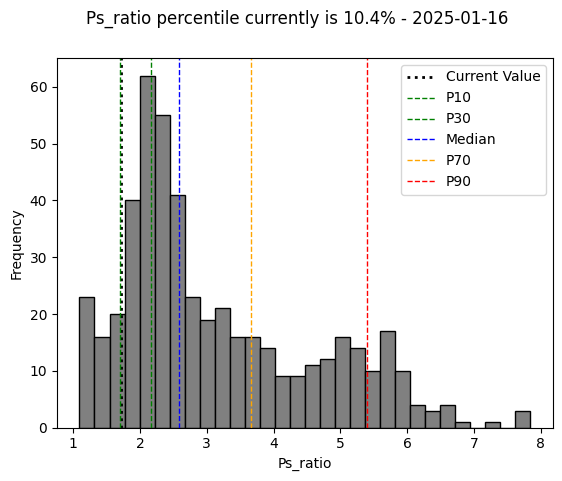

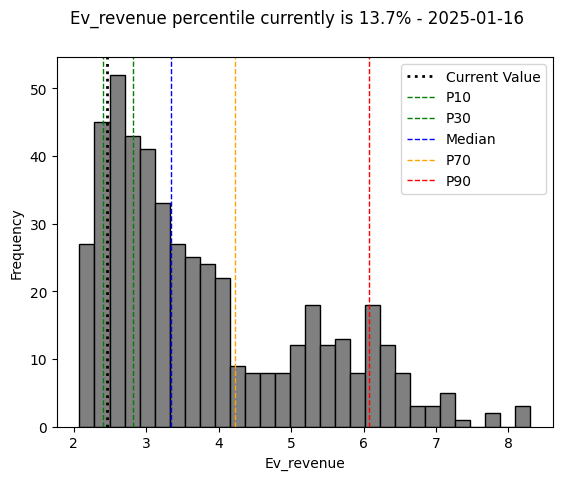

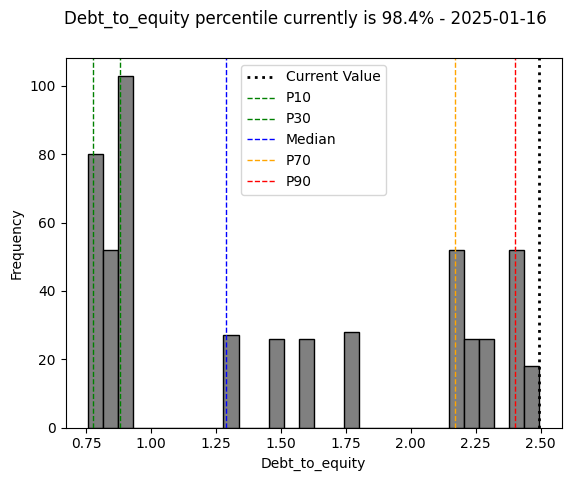

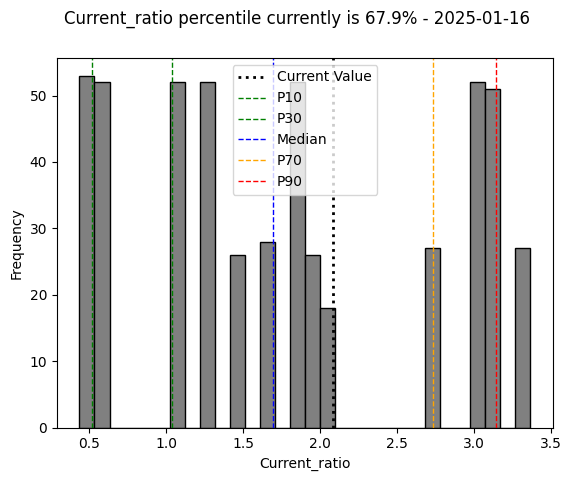

In [19]:
# plot histograms of value parameters
utils.plot_histogram_value_parameters(input_df=merged_nat_curr, extra_parameters=[], owned_shares=owned_shares)

## Calculate correlation between value parameters

In [20]:
# calulate value parameters Pearson's correlation coefficient
pd.DataFrame(merged_nat_curr, columns=['roa', 'roe', 'pe_ratio', 'pb_ratio', 'ps_ratio', 'ev_revenue', 'debt_to_equity', 'current_ratio']).corr()

,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,debt_to_equity,current_ratio
roa,1.000000,0.973512,0.010700,0.195994,0.312567,0.193083,-0.647206,0.445064
roe,0.973512,1.000000,0.073558,0.199500,0.325685,0.234427,-0.594550,0.309050
pe_ratio,0.010700,0.073558,1.000000,0.382980,0.298909,0.301504,0.058842,-0.152693
pb_ratio,0.195994,0.199500,0.382980,1.000000,0.924984,0.888221,-0.103033,-0.038724
ps_ratio,0.312567,0.325685,0.298909,0.924984,1.000000,0.967373,-0.282052,-0.097421
ev_revenue,0.193083,0.234427,0.301504,0.888221,0.967373,1.000000,-0.059719,-0.250252
debt_to_equity,-0.647206,-0.594550,0.058842,-0.103033,-0.282052,-0.059719,1.000000,-0.352108
current_ratio,0.445064,0.309050,-0.152693,-0.038724,-0.097421,-0.250252,-0.352108,1.000000


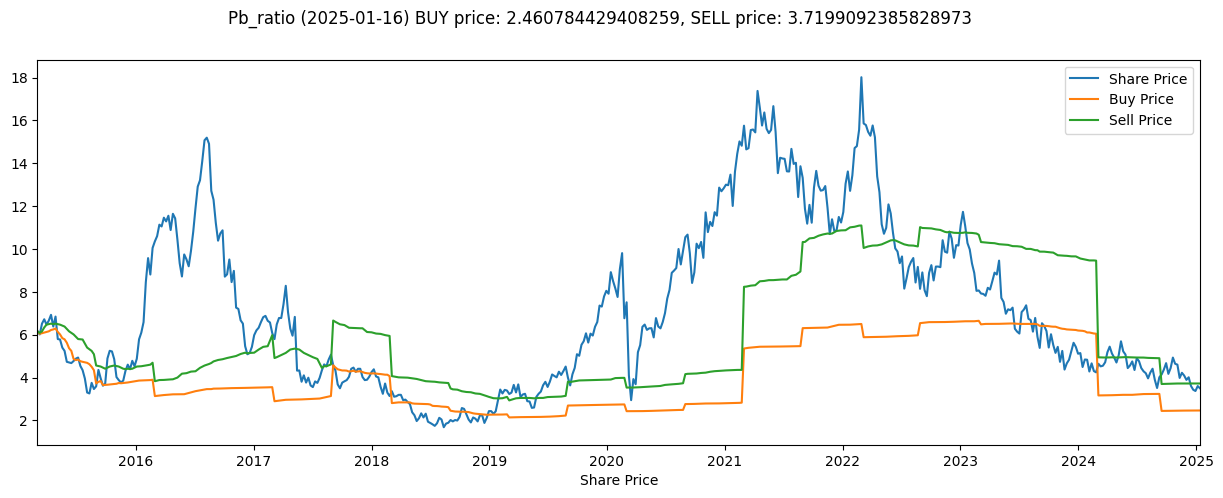

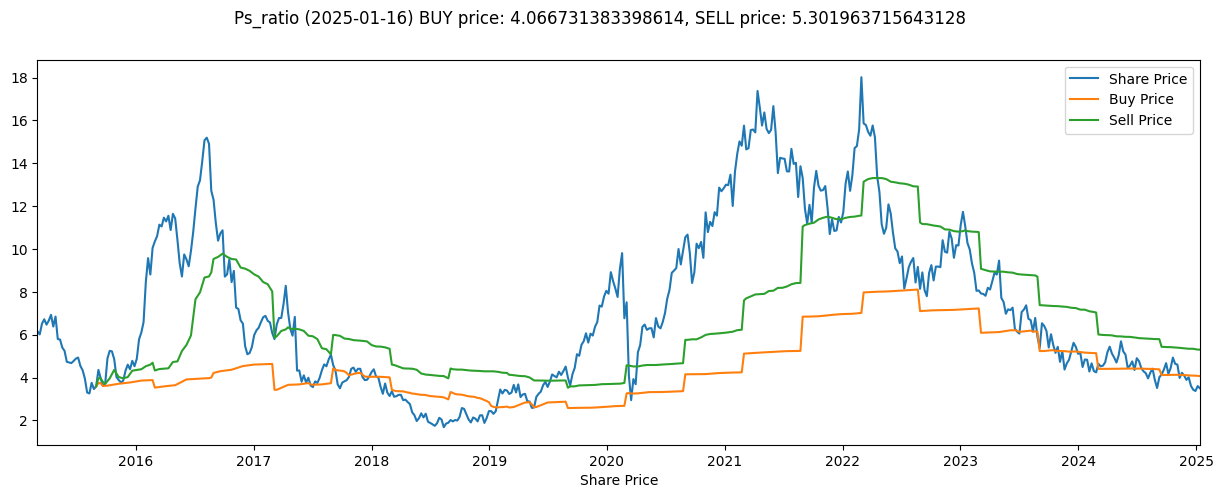

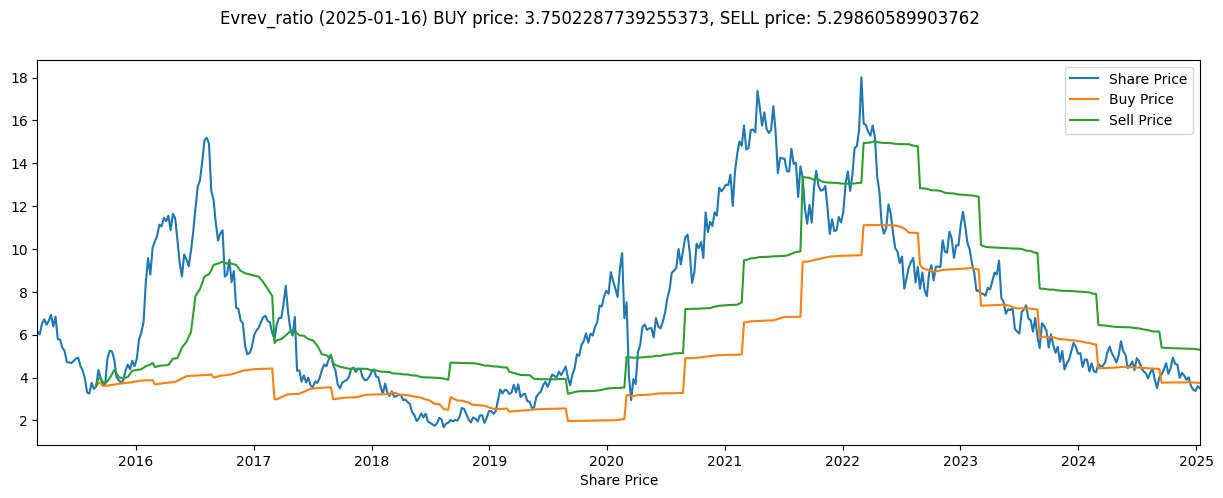

In [21]:
final_df = utils.get_value_stock_target_prices(
    input_df=merged_nat_curr,
    min_pct=0.2,
    max_pct=0.5,
    owned_shares=owned_shares
)